In [ ]:
!pip install transformers torch torchvision matplotlib opencv-python Pillow reportlab scikit-learn

In [16]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [11]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# --- 6. CARGAR MODELO PREENTRENADO Y AJUSTAR CAPA FINAL ---
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/davidmerlez/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 45.2MB/s]


In [12]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"\nÉpoca {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)
        print(f"Pérdida: {epoch_loss:.4f}, Precisión: {epoch_acc:.4f}")

    return model

In [13]:
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)


Época 1/5
Pérdida: 1.1200, Precisión: 0.5583

Época 2/5
Pérdida: 1.0276, Precisión: 0.6687

Época 3/5
Pérdida: 0.3490, Precisión: 0.8650

Época 4/5
Pérdida: 0.5011, Precisión: 0.8221

Época 5/5
Pérdida: 0.3564, Precisión: 0.8712


In [14]:
torch.save(model.state_dict(), "modelo_dano_auto.pth")


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Abolladuras       0.13      0.11      0.12        18
     Intacto       0.29      0.32      0.30        19
    Rallones       0.17      0.35      0.23        17
   Siniestro       0.00      0.00      0.00        19

    accuracy                           0.19        73
   macro avg       0.15      0.19      0.16        73
weighted avg       0.15      0.19      0.16        73


--- Matriz de Confusión ---


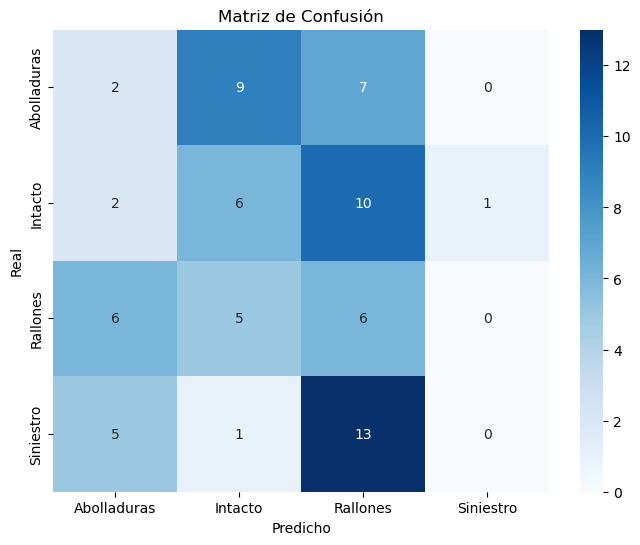

In [17]:
# --- 10. EVALUACIÓN DEL MODELO EN VALIDACIÓN ---
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n--- Reporte de Clasificación ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\n--- Matriz de Confusión ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

# --- 11. EJECUTAR EVALUACIÓN ---
evaluate_model(model, dataloaders['val'])

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Solo si tienes más de 1 clase
probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

binarized_labels = label_binarize(all_labels, classes=range(len(class_names)))
auc = roc_auc_score(binarized_labels, probs, average="macro", multi_class="ovr")
print(f"AUC promedio (macro): {auc:.4f}")

AUC promedio (macro): 0.4466


In [ ]:
def show_misclassified_images(model, dataloader, class_names, num_images=5):
    model.eval()
    wrong = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    wrong.append((inputs[i].cpu(), preds[i].cpu(), labels[i].cpu()))
                if len(wrong) >= num_images:
                    break
            if len(wrong) >= num_images:
                break

    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(wrong):
        img = img.permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Desnormaliza
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nReal: {class_names[true]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

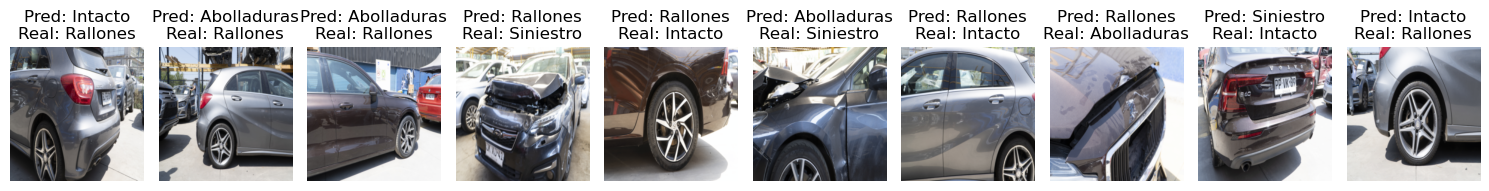

In [21]:
show_misclassified_images(model, dataloaders['val'], class_names, num_images=10)